In [49]:
import requests
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


pd.set_option('display.max_columns', None)


def CleanData(response):
    data = json.loads(response.text)
    df = pd.DataFrame.from_dict(data)

    #Remove first row from df 
    newcolumn = df.iloc[0]
    df = df.iloc[1:]

    #Rename columns
    df.rename(columns=newcolumn, inplace = True)

    #Reset index 
    df.reset_index(inplace = True, drop = True)

    return df


## base url for characteristics of businesses 
base = 'https://api.census.gov/data/2018/abscb?'

# Exploring Family Ownership

#### ------------------- family ownership and years in business --------------------------------

In [384]:
## a general look 

params_yb_famown = {
    'get' : 'GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,YIBSZFI,SEX,SEX_LABEL,ETH_GROUP,ETH_GROUP_LABEL,RACE_GROUP,RACE_GROUP_LABEL,VET_GROUP,VET_GROUP_LABEL,QDESC,QDESC_LABEL,BUSCHAR,BUSCHAR_LABEL,YEAR,FIRMPDEMP,FIRMPDEMP_F,FIRMPDEMP_PCT,FIRMPDEMP_PCT_F,RCPPDEMP,RCPPDEMP_F,RCPPDEMP_PCT,RCPPDEMP_PCT_F,EMP,EMP_F,EMP_PCT,EMP_PCT_F,PAYANN,PAYANN_F,PAYANN_PCT,PAYANN_PCT_F,FIRMPDEMP_S,FIRMPDEMP_S_F,FIRMPDEMP_PCT_S,FIRMPDEMP_PCT_S_F,RCPPDEMP_S,RCPPDEMP_S_F,RCPPDEMP_PCT_S,RCPPDEMP_PCT_S_F,EMP_S,EMP_S_F,EMP_PCT_S,EMP_PCT_S_F,PAYANN_S,PAYANN_S_F,PAYANN_PCT_S,PAYANN_PCT_S_F',
    'for' : 'us',
    'QDESC_LABEL' : 'FAMOWN',
    'key' : '10bf25bcce0f90f77afc9446298738e209ce9d58' 
}
response_yb_famown = requests.get(base, params = params_yb_famown)

yb_famown = CleanData(response_yb_famown)


## Create df that focuses on total for all sectors (NAICS2017 = 00), and disregards veteran, ethnicity, race, and sex group. 
yb = yb_famown[(yb_famown.VET_GROUP == '001') & (yb_famown.SEX == '001') & (yb_famown.ETH_GROUP == '001') & (yb_famown.NAICS2017 == '00') & (yb_famown.RACE_GROUP == '00')]


## Selecting columns and rows
yb = yb[['YIBSZFI', 'BUSCHAR', 'BUSCHAR_LABEL', 'FIRMPDEMP', 'FIRMPDEMP_PCT', 'RCPPDEMP', 'EMP', 'EMP_PCT', 'PAYANN', 'PAYANN_PCT']]

## Removing rows where YIBSZFI is aggregated ('totals')
yb = yb[yb.YIBSZFI != '001']

## Only keeping family and not family owned. Removing item not reported and total rows 
yb = yb[(yb.BUSCHAR == 'BM') | (yb.BUSCHAR == 'BN')]

## Changing datatypes
yb = yb.astype({"FIRMPDEMP": "int", "FIRMPDEMP_PCT": "float", "RCPPDEMP": "int64", "EMP": "int64", "EMP_PCT": "float", "PAYANN": "int64", "PAYANN_PCT": "float"})

## Sorting
yb.sort_values(by = ['YIBSZFI'], inplace= True)
yb.reset_index(inplace = True, drop = True)

## Replacing codes with descriptive values
yb.YIBSZFI.replace('311', 'less than 2', inplace=True)
yb.YIBSZFI.replace('318', '2 to 3', inplace=True)
yb.YIBSZFI.replace('319', '4 to 5', inplace=True)
yb.YIBSZFI.replace('321', '6 to 10', inplace=True)
yb.YIBSZFI.replace('322', '11 to 15', inplace=True)
yb.YIBSZFI.replace('323', '16 +', inplace=True)


yb

,YIBSZFI,BUSCHAR,BUSCHAR_LABEL,FIRMPDEMP,FIRMPDEMP_PCT,RCPPDEMP,EMP,EMP_PCT,PAYANN,PAYANN_PCT
0,less than 2,BM,Family-owned,58403,24.7,37730276,297945,27.7,8629168,24.5
1,less than 2,BN,Not family-owned,177725,75.3,118497006,775859,72.3,26568681,75.5
2,2 to 3,BM,Family-owned,84089,25.7,78706219,545655,27.0,16604437,26.2
3,2 to 3,BN,Not family-owned,242514,74.3,200841567,1473911,73.0,46678795,73.8
4,4 to 5,BM,Family-owned,66709,26.3,75707166,483986,29.7,15366568,25.4
5,4 to 5,BN,Not family-owned,186678,73.7,186535797,1147235,70.3,45221266,74.6
6,6 to 10,BM,Family-owned,129108,27.8,162762860,1159157,33.6,38819092,26.9
7,6 to 10,BN,Not family-owned,334935,72.2,418575581,2293629,66.4,105455713,73.1
8,11 to 15,BM,Family-owned,133329,31.3,184964523,1127914,35.1,41192854,31.2
9,11 to 15,BN,Not family-owned,292920,68.7,391573905,2081775,64.9,91044903,68.8


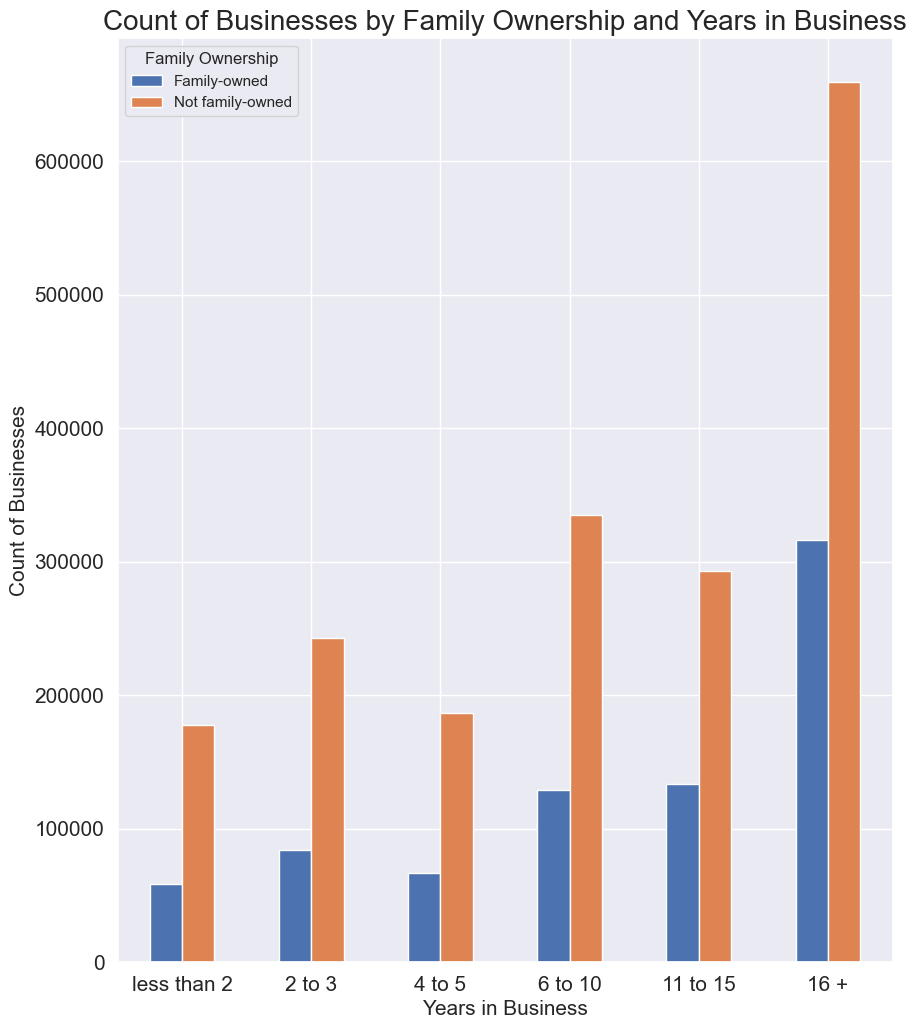

In [507]:
### Visualization: Clustered Bar

# grouping
yb_famown_count = yb.groupby(['YIBSZFI', 'BUSCHAR_LABEL'])['FIRMPDEMP'].sum().unstack().fillna(0)

# sorting 
sort_dict = {'less than 2':0,'2 to 3':1,'4 to 5':2, '6 to 10':3, '11 to 15':4, '16 +':5}
yb_famown_count['new'] = yb_famown_count.index
yb_famown_count['sortmap'] = yb_famown_count['new'].map(lambda x: sort_dict[x])
yb_famown_count = yb_famown_count.sort_values('sortmap')

# Removing field added for sorting
yb_famown_count_VIS = yb_famown_count[["Family-owned", "Not family-owned"]]

# Plot
plt.rcParams["figure.figsize"] = (10,12)

yb_famown_count_VIS.plot(kind='bar', stacked=False)
plt.title('Count of Businesses by Family Ownership and Years in Business', fontsize=20)
plt.ylabel('Count of Businesses', fontsize = 15)
plt.xlabel('Years in Business', fontsize = 15)
plt.xticks(rotation=0, ha='center', fontsize = 15)
plt.yticks(rotation=0, fontsize = 15)
plt.legend(title='Family Ownership')


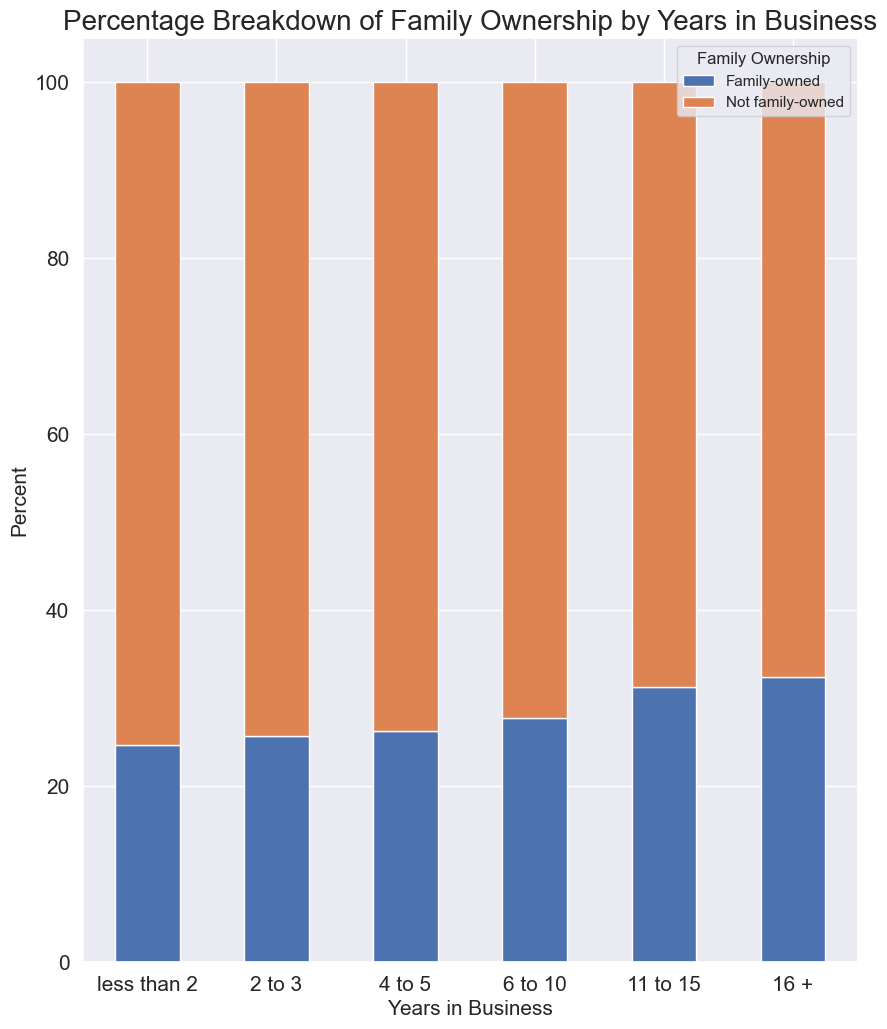

In [508]:
### Visualization: 100% Stacked Bar


# grouping
yb_famown_pct = yb.groupby(['YIBSZFI', 'BUSCHAR_LABEL'])['FIRMPDEMP_PCT'].sum().unstack().fillna(0)

# sorting
sort_dict = {'less than 2':0,'2 to 3':1,'4 to 5':2, '6 to 10':3, '11 to 15':4, '16 +':5}
yb_famown_pct['new'] = yb_famown_pct.index
yb_famown_pct['sortmap'] = yb_famown_pct['new'].map(lambda x: sort_dict[x])
yb_famown_pct = yb_famown_pct.sort_values('sortmap')

# Removing field added for sorting
yb_famown_pct_VIS = yb_famown_pct[["Family-owned", "Not family-owned"]]

# plot
plt.rcParams["figure.figsize"] = (10,12)

yb_famown_pct_VIS.plot(kind='bar', stacked=True)
plt.title('Percentage Breakdown of Family Ownership by Years in Business', fontsize = 20)
plt.ylabel('Percent', fontsize = 15)
plt.xlabel('Years in Business', fontsize = 15)
plt.yticks(rotation=0, fontsize = 15)
plt.xticks(rotation=0, ha='center', fontsize = 15)
plt.legend(title='Family Ownership')


#### drilling in on sex group

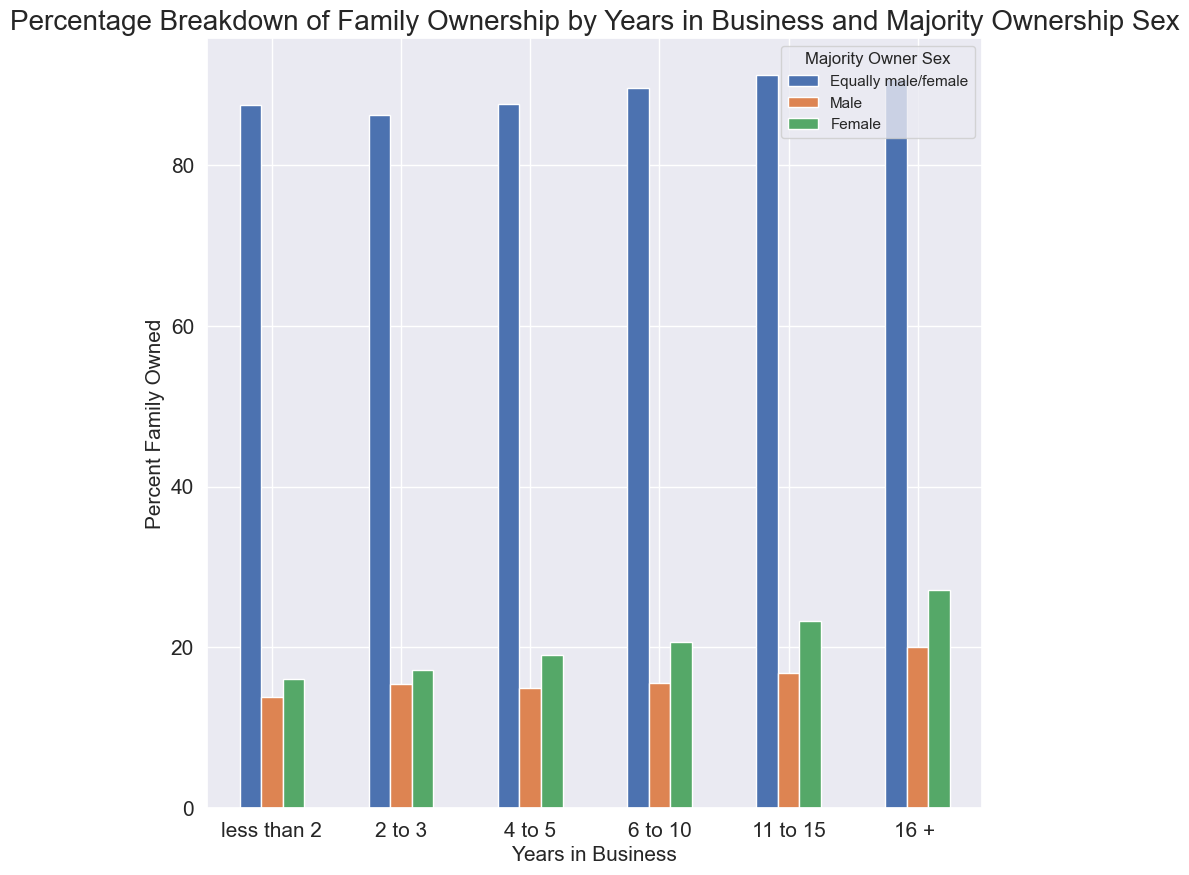

In [527]:

## Create df that focuses on total for all sectors (NAICS2017 = 00), and disregards veteran, and ethnicity group. 
yb_sex = yb_famown[(yb_famown.VET_GROUP == '001') & (yb_famown.RACE_GROUP == '00') & (yb_famown.ETH_GROUP == '001') & (yb_famown.NAICS2017 == '00')]

## Selecting columns and rows
yb_sex= yb_sex[['YIBSZFI', 'SEX_LABEL', 'BUSCHAR', 'BUSCHAR_LABEL', 'FIRMPDEMP', 'FIRMPDEMP_PCT', 'RCPPDEMP', 'EMP', 'EMP_PCT', 'PAYANN', 'PAYANN_PCT']]
yb_sex = yb_sex[yb_sex.YIBSZFI != '001']
## Only keeping Family Owned Businesses 
yb_sex = yb_sex[(yb_sex.BUSCHAR == 'BM')]
## Removing sex = total 
yb_sex = yb_sex[yb_sex.SEX_LABEL != 'Total']

## Replacing codes with descriptive values
yb_sex.YIBSZFI.replace('311', 'less than 2', inplace=True)
yb_sex.YIBSZFI.replace('318', '2 to 3', inplace=True)
yb_sex.YIBSZFI.replace('319', '4 to 5', inplace=True)
yb_sex.YIBSZFI.replace('321', '6 to 10', inplace=True)
yb_sex.YIBSZFI.replace('322', '11 to 15', inplace=True)
yb_sex.YIBSZFI.replace('323', '16 + ', inplace=True)

## Changing datatypes
yb_sex = yb_sex.astype({"FIRMPDEMP": "int", "FIRMPDEMP_PCT": "float", "RCPPDEMP": "int64", "EMP": "int64", "EMP_PCT": "float", "PAYANN": "int64", "PAYANN_PCT": "float"})

# Pivoting df
yb_sex_pivoted = yb_sex.pivot(index='YIBSZFI', columns='SEX_LABEL', values='FIRMPDEMP_PCT')

# Sorting
sort_dict = {'less than 2':0,'2 to 3':1,'4 to 5':2, '6 to 10':3, '11 to 15':4, '16 + ':5}
yb_sex_pivoted['new'] = yb_sex_pivoted.index
yb_sex_pivoted['sortmap'] = yb_sex_pivoted['new'].map(lambda x: sort_dict[x])
yb_sex_pivoted = yb_sex_pivoted.sort_values('sortmap')

# Removing field added for sorting
yb_sex_pivoted_VIS = yb_sex_pivoted[["Equally male/female", "Male", "Female"]]

# Plot
plt.rcParams["figure.figsize"] = (10,10)

yb_sex_pivoted_VIS.plot(kind='bar')
plt.title('Percentage Breakdown of Family Ownership by Years in Business and Majority Ownership Sex', fontsize = 20)
plt.ylabel('Percent Family Owned', fontsize = 15)
plt.xlabel('Years in Business', fontsize = 15)
plt.yticks(rotation=0, fontsize = 15)
plt.xticks(rotation=0, ha='center', fontsize = 15)
plt.legend(title='Majority Owner Sex')

#### ------------------- family ownership by state --------------------------------

In [451]:

params_famown_state = {
    'get' : 'GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,SEX,SEX_LABEL,ETH_GROUP,ETH_GROUP_LABEL,RACE_GROUP,RACE_GROUP_LABEL,VET_GROUP,VET_GROUP_LABEL,QDESC,QDESC_LABEL,BUSCHAR,BUSCHAR_LABEL,YEAR,FIRMPDEMP,FIRMPDEMP_F,FIRMPDEMP_PCT,FIRMPDEMP_PCT_F,RCPPDEMP,RCPPDEMP_F,RCPPDEMP_PCT,RCPPDEMP_PCT_F,EMP,EMP_F,EMP_PCT,EMP_PCT_F,PAYANN,PAYANN_F,PAYANN_PCT,PAYANN_PCT_F,FIRMPDEMP_S,FIRMPDEMP_S_F,FIRMPDEMP_PCT_S,FIRMPDEMP_PCT_S_F,RCPPDEMP_S,RCPPDEMP_S_F,RCPPDEMP_PCT_S,RCPPDEMP_PCT_S_F,EMP_S,EMP_S_F,EMP_PCT_S,EMP_PCT_S_F,PAYANN_S,PAYANN_S_F,PAYANN_PCT_S,PAYANN_PCT_S_F',
    'for' : 'state',
    'QDESC_LABEL' : 'FAMOWN',
    'key' : '10bf25bcce0f90f77afc9446298738e209ce9d58' 
}
response_famown_state = requests.get(base, params = params_famown_state)

famown_state = CleanData(response_famown_state)


## Selecting columns and rows
famown_state = famown_state[['NAME', 'BUSCHAR', 'BUSCHAR_LABEL', 'FIRMPDEMP', 'FIRMPDEMP_PCT']]
famown_state = famown_state[famown_state.BUSCHAR == 'BM']


## Changing datatypes
famown_state = famown_state.astype({"FIRMPDEMP": "int", "FIRMPDEMP_PCT": "float"})



In [452]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

# Replacing state names with abbreviations
famown_state['NAME'] = famown_state['NAME'].replace(us_state_to_abbrev)

,NAME,BUSCHAR,BUSCHAR_LABEL,FIRMPDEMP,FIRMPDEMP_PCT
1,MS,BM,Family-owned,4744,28.7
7,MO,BM,Family-owned,18034,35.3
13,MT,BM,Family-owned,6419,40.6
19,NE,BM,Family-owned,8466,39.0
25,NV,BM,Family-owned,5855,30.1
31,NH,BM,Family-owned,2956,22.8
37,NJ,BM,Family-owned,19410,24.0
43,NM,BM,Family-owned,5038,37.5
49,NY,BM,Family-owned,38139,21.2
55,NC,BM,Family-owned,25107,29.9


In [454]:

# Choropleth map for the data

fig = px.choropleth(famown_state, locations='NAME',
                    locationmode="USA-states", color='FIRMPDEMP_PCT', scope="usa")
 
fig.show()

In [528]:
# Choropleth second try

fig = go.Figure(data=go.Choropleth(
    locations=famown_state['NAME'], # Spatial coordinates
    z = famown_state['FIRMPDEMP_PCT'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Greens',
    colorbar_title = "Percent of Family Owned Businesses",
))

fig.update_layout(
    title_text = 'Proportion of Family Owned Businesses by State',
    geo_scope='usa', # limite map scope to USA
)



#### ------------------- family ownership by industry --------------------------------

In [514]:

## Create df that disregards veteran, ethnicity, race, and sex group. Focuses on industry
famown_industry = yb_famown[(yb_famown.VET_GROUP == '001') & (yb_famown.SEX == '001') & (yb_famown.ETH_GROUP == '001') & (yb_famown.NAICS2017 != '00') & (yb_famown.RACE_GROUP == '00')]


## Selecting columns and rows
famown_industry = famown_industry[['NAICS2017_LABEL', 'BUSCHAR', 'BUSCHAR_LABEL', 'FIRMPDEMP', 'FIRMPDEMP_PCT', 'RCPPDEMP', 'EMP', 'EMP_PCT', 'PAYANN', 'PAYANN_PCT']]


## Only keeping family and not family owned. Removing item not reported and total rows 
famown_industry = famown_industry[(famown_industry.BUSCHAR == 'BM')]


## Changing datatypes
famown_industry = famown_industry.astype({"FIRMPDEMP": "int", "FIRMPDEMP_PCT": "float", "RCPPDEMP": "int64", "EMP": "int64", "EMP_PCT": "float", "PAYANN": "int64", "PAYANN_PCT": "float"})

## Sorting 
famown_industry.sort_values(by = ["FIRMPDEMP_PCT"], inplace = True)

## Plot
fig = px.bar(famown_industry, x="FIRMPDEMP_PCT", y="NAICS2017_LABEL", orientation='h')

fig.update_layout(
    title="Percentage of Family Owned Businesses by Industry",
    xaxis_title="Percent Family Owned",
    yaxis_title="Industry",
    font=dict(
        size=10,
    )
)

fig.show()